![bookstore](bookstore.jpg)


Identifying popular products is incredibly important for e-commerce companies! Popular products generate more revenue and, therefore, play a key role in stock control.

You've been asked to support an online bookstore by building a model to predict whether a book will be popular or not. They've supplied you with an extensive dataset containing information about all books they've sold, including:

* `price`
* `popularity` (target variable)
* `review/summary`
* `review/text`
* `review/helpfulness`
* `authors`
* `categories`

You'll need to build a model that predicts whether a book will be rated as popular or not.

They have high expectations of you, so have set a target of at least 70% accuracy! You are free to use as many features as you like, and will need to engineer new features to achieve this level of performance.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15719 entries, 0 to 15718
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               15719 non-null  object 
 1   price               15719 non-null  float64
 2   review/helpfulness  15719 non-null  object 
 3   review/summary      15719 non-null  object 
 4   review/text         15719 non-null  object 
 5   description         15719 non-null  object 
 6   authors             15719 non-null  object 
 7   categories          15719 non-null  object 
 8   popularity          15719 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


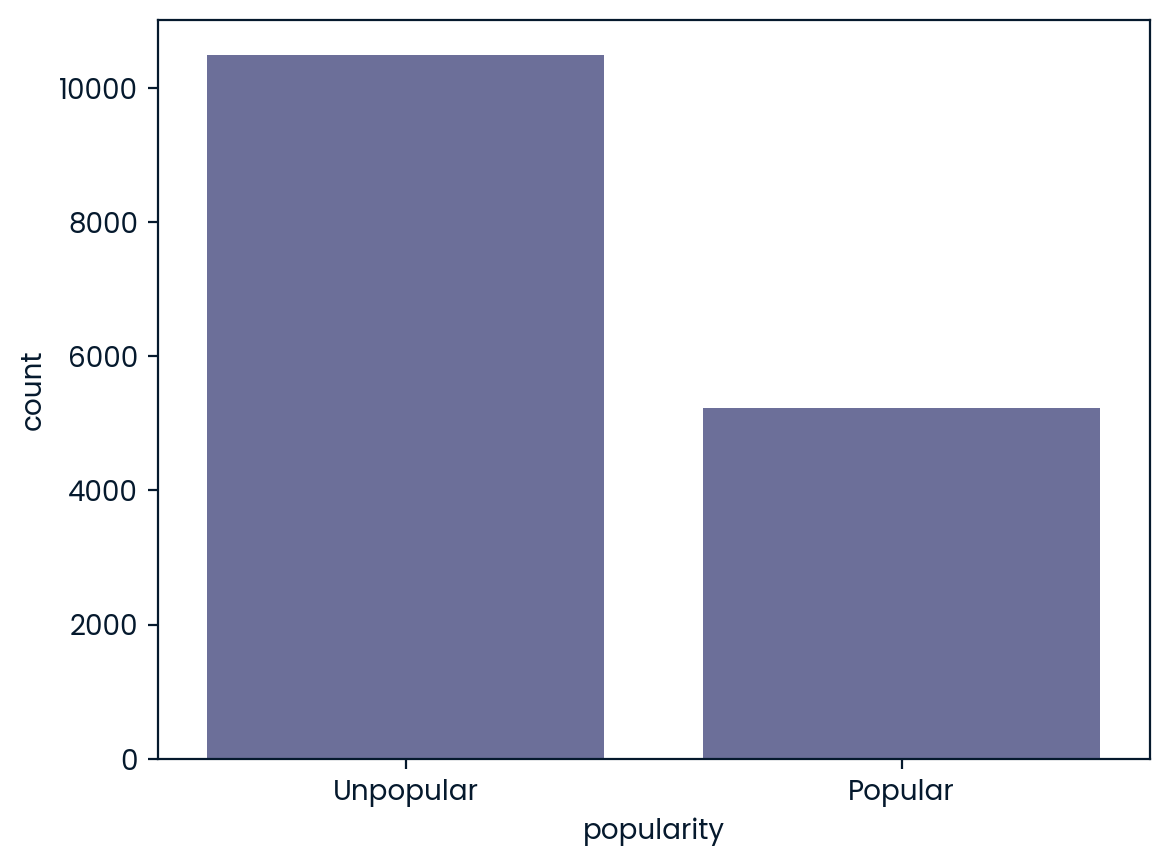

'Fiction'                      3520
'Religion'                     1053
'Biography & Autobiography'     852
'Juvenile Fiction'              815
'History'                       754
                               ... 
'Sunflowers'                      1
'Self-confidence'                 1
'United States'                   1
'Note-taking'                     1
'Asthma'                          1
Name: categories, Length: 313, dtype: int64
0.9617126389460683
0.7090036014405763


In [2]:
# Import some required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  

# Read in the dataset
books = pd.read_csv("data/books.csv")

# Inspect the DataFrame
books.info()

# Visualize popularity frequencies
sns.countplot(data=books, x="popularity")
plt.show()

# Check frequencies
print(books["categories"].value_counts())

# Filter out rare categories to avoid overfitting
books = books.groupby("categories").filter(lambda x: len(x) > 100)

# One-hot encoding categories
categories = pd.get_dummies(books["categories"], drop_first=True)

# Bring categories into the DataFrame
books = pd.concat([books, categories], axis=1)

# Remove original column
books.drop(columns=["categories"], inplace=True)

# Get number of total reviews 
books["num_reviews"] = books["review/helpfulness"].str.split("/", expand=True)[1]

# Get number of helpful reviews 
books["num_helpful"] = books["review/helpfulness"].str.split("/", expand=True)[0]

# Convert to integer datatype
for col in ["num_reviews", "num_helpful"]:
    books[col] = books[col].astype(int)
    
# Add percentage of helpful reviews as a column to normalize the data
books["perc_helpful_reviews"] = books["num_helpful"] / books["num_reviews"]

# Fill null values
books["perc_helpful_reviews"].fillna(0, inplace=True)

# Drop original column
books.drop(columns=["review/helpfulness"], inplace=True)

# Convert strings to lowercase
for col in ["review/summary", "review/text", "description"]:
    books[col] = books[col].str.lower()
    
# Create a list of positive words to measure positive text sentiment
positive_words = ["great", "excellent", "good", "interesting", "enjoy", "helpful", "useful", "like", "love", "beautiful", "fantastic", "perfect", "wonderful", "impressive", "amazing", "outstanding", "remarkable", "brilliant", "exceptional", "positive",
    "thrilling"]

# Instantiate a CountVectorizer
vectorizer = CountVectorizer(vocabulary=positive_words)

# Fit and transform review/text 
review_text = books["review/text"]
text_transformed = vectorizer.fit_transform(review_text.fillna(''))

# Fit and transform review/summary
review_summary = books["review/summary"]
summary_transformed = vectorizer.fit_transform(review_summary.fillna(''))

# Fit and transform description
description = books["description"]
description_transformed = vectorizer.fit_transform(description.fillna(''))

# Add positive counts into DataFrame to add measures of positive sentiment
books["positive_words_text"] = text_transformed.sum(axis=1).reshape(-1, 1)
books["positive_words_summary"] = summary_transformed.sum(axis=1).reshape(-1, 1)
books["positive_words_description"] = description_transformed.sum(axis=1).reshape(-1, 1)

# Remove original columns
books.drop(columns=["review/text", "review/summary", "description"], inplace=True)

# Splitting into features and target values
X = books.drop(columns=["title", "authors", "popularity"]).values
y = books["popularity"].values.reshape(-1, 1)

# Splitting into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and fit a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=120, max_depth=50, min_samples_split=5, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train.ravel()) 

# Evaluate accuracy
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

model_accuracy = clf.score(X_test, y_test)